<h1 align='Center'>
<img src="https://assets.digihaul.com/images/logo.png" width="350" height="550" align="center"/>
</h1>
<h3 align='center'> Task 2</h3>

### Problem Statement

Road haulage is essential for the people and businesses of the UK. Approximately 90% of all goods transported by land in Great Britain are moved directly by road. DigiHaul is a digital transport business, specialising in managing, consolidating and integrating data from both Carriers and Shippers to deliver seamless end-to-end logistics service.
Shippers book shipments on the DigiHaul platform, detailing the scheduled collection and delivery time windows / locations and required vehicle types for carriers to consider. Once a carrier accepts a job and collection is scheduled, DigiHaul’s driver app facilitates real-time tracking of shipments through GPS signals, subject to carriers granting permissions for location logging.


#### Python packages:

- data handling packages   : pandas, regex, numpy, math
- modelling packages       : sklearn
- geolocation packages     : google maps

In [404]:
# Importing data handling python packages

import pandas as pd
import re
import googlemaps
import numpy as np
from math import radians
import warnings
import matplotlib.pyplot as plt
from sklearn.neighbors import DistanceMetric
import googlemaps

dist = DistanceMetric.get_metric("haversine")
g_client = googlemaps.Client(key="Enter your key here")

warnings.filterwarnings("ignore")

### Input data:

Three datasets are provided for working with the tasks and each one of them are in .csv format

1. gps_data.csv: contains GPS logging(latitude and longitude) for each shipment along with the timestamp details

2. shipment.csv: contains all the details about each shipment initiated, with the details of shipper, details of carries, collection and delivery - postcode, latitude, longitude and time

3. shipment_gps_data.csv: contains only shipments for which valid GPS information is captured

In [405]:
# reading in input datasets

gps_data = pd.read_csv("./Test/GPS_data.csv")
shipment = pd.read_csv("./Test/Shipment_bookings.csv")
valid_ship_gps = pd.read_csv(
    "./shipment_gps_data.csv"
)  # shipments with valid GPS logs (re-using data created from Task 1)

### Pre-processing:

1. Time stamp formatting: time-stamp details captured by the system are not in a recognizable format for the python to handle and hence it is converted to suit python needs

2. Datatype conversion: all the shipment numbers are type casted to 'string' data type for sanitary reasons

3. Missing data: Records with no GPS details(latitude and longitude measures missing) are removed from the datset

In [406]:
#### Formatting time-stamp columns and performing datatype conversion


def format_time_stamp(input_col_name, output_col_name, file):
    """
    Function to format the input time stamp to python understandable format
    Args:
        input_col_name (str): name of input column with time-stamp
        output_col_name(str): name of new output column to fill the generated output
        file           (str): file name to chose the correct dataframe to use
    Returns:
        Changes the dataframes with new columns
    """
    if file == "gps":
        gps_data[output_col_name] = pd.to_datetime(
            gps_data[input_col_name].apply(
                lambda x: (
                    re.sub("T", " ", x[:-9])
                    if "Z" not in x
                    else re.sub("T", " ", x[:-5])
                )
            )
        )
    else:
        shipment[output_col_name] = pd.to_datetime(
            shipment[input_col_name].apply(
                lambda x: (
                    re.sub("T", " ", x[:-9])
                    if "Z" not in x
                    else re.sub("T", " ", x[:-5])
                )
            )
        )


format_time_stamp("RECORD_TIMESTAMP", "FORMATTED_GPS_TIMESTAMP", "gps")
format_time_stamp(
    "LAST_DELIVERY_SCHEDULE_LATEST", "FORMATTED_DELIVERY_SCHEDULE_LATEST", "shipment"
)
format_time_stamp(
    "LAST_DELIVERY_SCHEDULE_EARLIEST",
    "FORMATTED_DELIVERY_SCHEDULE_EARLIEST",
    "shipment",
)
format_time_stamp(
    "FIRST_COLLECTION_SCHEDULE_LATEST", "FROMATTED_FIRST_COLLECTION_LATEST", "shipment"
)
format_time_stamp(
    "FIRST_COLLECTION_SCHEDULE_EARLIEST",
    "FROMATTED_FIRST_COLLECTION_EARLIEST",
    "shipment",
)


# datatype conversion
shipment["SHIPMENT_NUMBER"] = shipment["SHIPMENT_NUMBER"].astype("str")
gps_data["SHIPMENT_NUMBER"] = gps_data["SHIPMENT_NUMBER"].astype("str")


# removing shipments were LAT LON details are not logged in GPS data
gps_data = gps_data[gps_data["LON"] != 0.0]

## Task 2 

Timely communication of potential delays is crucial for shippers. During the 3-month period from 1st Oct to 31st Dec 2023, which shipper(s) should be notified automatically regarding potential late delivery of which shipments, and at what times?


Steps:
1. Getting all GPS logs for valid delivery data from the previous question
2. Use Google distance API to calculate distance and ETA between current geo location and destination location
3. Constraint and sample creation
4. Analysis to identify the threshold for allowed range of time difference between target time and google ETA 
5. Whom and when to send?

### Step 1:  Getting all GPS logs for valid delivery data from the previous question

From the previous questions we have acquired the profiled data based on delivery and GPS logs,
Advanced delivery, Threshold delivery, Late delivert and Imcomplete logs. All the GPS logs available for these shipments are gathered by joining with GPS dataset

In [407]:
# Subset only required columns and join the GPS data
valid_ship_num = pd.DataFrame(
    valid_ship_gps[
        [
            "SHIPMENT_NUMBER",
            "LAST_DELIVERY_LATITUDE",
            "LAST_DELIVERY_LONGITUDE",
            "FORMATTED_DELIVERY_SCHEDULE_LATEST",
            "DELIVERED_LATE_BY_TIME?",
            "INDICATOR",
        ]
    ]
)
gps_shipment_data = valid_ship_num.merge(gps_data, how="left", on="SHIPMENT_NUMBER")

gps_shipment_data["FORMATTED_DELIVERY_SCHEDULE_LATEST"] = pd.to_datetime(
    gps_shipment_data["FORMATTED_DELIVERY_SCHEDULE_LATEST"]
)

### Step 2: Use Google distance API to calculate distance and ETA between current geo location and destination location

- Method to connect to Google distance API to retreive distance and ETA between geo locations
- Method to calculate haversine distance between geo locations
- Method to retreive ETA using OSRM between two geo locations



In [408]:
def get_transit_details_google(x):
    """
    Function to do API call to Google Distance API to retreive distance and ETA between two locations
    Args:
        x (row iter): row iter from the lambda function call
    Returns:
        distance in km
        time in mins
    """
    source = str(x["LAT"]) + "," + str(x["LON"])
    destination = (
        str(x["LAST_DELIVERY_LATITUDE"]) + "," + str(x["LAST_DELIVERY_LONGITUDE"])
    )
    result = g_client.directions(
        source, destination, mode="driving", avoid="ferries", transit_mode="bus"
    )
    distance = result[0]["legs"][0]["distance"]["value"]
    time = result[0]["legs"][0]["duration"]["value"]
    return distance / 1000, time / 60


# Calculate the distance between the GPS location and the delivery location
R = 6373.0  # approx radius of earth in km


def haversine(x):
    """
    Function to calculate distance between two location using Haversine distance formula
    Args:
        x (row iter): row iter from the lambda function call
    Returns:
        distance in km
    """
    X = [
        [radians(x["LAT"]), radians(x["LON"])],
        [radians(x["LAST_DELIVERY_LATITUDE"]), radians(x["LAST_DELIVERY_LONGITUDE"])],
    ]
    distance_sklearn = R * dist.pairwise(X)
    # print( np.array(distance_sklearn).item(1))
    return np.array(distance_sklearn).item(1)


def get_transit_details_osrm(x):
    """
    Function to calculate ETA between two location using osrm distance formula
    Args:
        x (row iter): row iter from the lambda function call
    Returns:
        time in hours
    """
    start_latitude = x["LAT"]
    start_longitude = x["LON"]
    end_latitude = x["LAST_DELIVERY_LATITUDE"]
    end_longitude = x["LAST_DELIVERY_LONGITUDE"]
    url = f"http://router.project-osrm.org/route/v1/driving/{start_longitude},{start_latitude};{end_longitude},{end_latitude}?overview=false"
    response = requests.get(url).json()
    distance = response.get("routes", [])[0].get("distance")
    time = response.get("routes", [])[0].get("duration")
    return time / 3600

### Step 3: Constraint and sample creation

Note: Since Google distance API free tier can support only limited number of requestes for free, scoring the entire data provided (~600k) is expensive and also time consuming

A sample is created which is representative of all the profiles discussed earlier and also suit the minimal payload for API query with google. Make sure the distribution of the sample is representative.

In [409]:
sample = pd.read_csv("sample_1_final.csv")
sample["FORMATTED_DELIVERY_SCHEDULE_LATEST"] = pd.to_datetime(
    sample["FORMATTED_DELIVERY_SCHEDULE_LATEST"]
)
sample["FORMATTED_GPS_TIMESTAMP"] = pd.to_datetime(sample["FORMATTED_GPS_TIMESTAMP"])
sample["TIME_LEFT_TILL_SET_DELIVERY_SCHEDULE"] = (
    sample["FORMATTED_DELIVERY_SCHEDULE_LATEST"] - sample["FORMATTED_GPS_TIMESTAMP"]
).dt.total_seconds() / 60

sample["INDICATOR"].value_counts()

advanced_delivery                  1728
late_delivery                       649
threshold_delivery                  160
incomplete_logs_potential_delay      13
Name: INDICATOR, dtype: int64

### Step 4: Analysis to identify the threshold for allowed range of time difference between target time and google ETA 

- Different threholds are set in iteration like 1%, 2%, 3%, 5%, 10%, 15%, 20% and 30% (of total ETA)
- Eevry log in the GPS file is tested difference between target time left to reach destination and google ETA
- If the difference is more than the selected threshold then we set an "ALERT" to send notification to shippers


In [410]:
time_threshold_df = (
    sample.groupby("SHIPMENT_NUMBER")["TIME_LEFT_TILL_SET_DELIVERY_SCHEDULE"].max()
    * 0.30
).reset_index(name="TIME_THRESHOLD_FOR_DELAY_ALERT")
sample = sample.merge(time_threshold_df, on="SHIPMENT_NUMBER", how="left")

In [411]:
def delay_alert(x):
    time_diff = (
        x["TIME_LEFT_TILL_SET_DELIVERY_SCHEDULE"] - x["TIME_TO_DESTINATION_MINS"]
    )
    if time_diff > 0:
        return 0
    elif time_diff < 0 or time_diff == 0:
        if abs(time_diff) > x["TIME_THRESHOLD_FOR_DELAY_ALERT"]:
            return 1
        else:
            return 0

In [412]:
sample["ALERT_INDICATOR"] = sample.apply(lambda x: delay_alert(x), axis=1)

In [413]:
a = (
    sample.groupby(["SHIPMENT_NUMBER", "DELIVERED_LATE_BY_TIME?"])["ALERT_INDICATOR"]
    .max()
    .reset_index(name="ALERT")
)

In [414]:
result = [
    ["1%", 13 * 100 / 15, 7 * 100 / 9, 7 * 100 / 7],
    ["2%", 12 * 100 / 15, 6 * 100 / 8, 6 * 100 / 7],
    ["3%", 12 * 100 / 15, 6 * 100 / 8, 6 * 100 / 7],
    ["5%", 13 * 100 / 15, 6 * 100 / 7, 6 * 100 / 7],
    ["10%", 12 * 100 / 15, 5 * 100 / 6, 5 * 100 / 7],
    ["15%", 12 * 100 / 15, 5 * 100 / 6, 5 * 100 / 7],
    ["20%", 12 * 100 / 15, 5 * 100 / 6, 5 * 100 / 7],
    ["30%", 12 * 100 / 15, 5 * 100 / 6, 5 * 100 / 7],
]

result_df = pd.DataFrame(
    result, columns=["Threshold%", "Accuracy", "Precision(Delay)", "Recall(Delay)"]
)

In [415]:
result_df

,Threshold%,Accuracy,Precision(Delay),Recall(Delay)
0,1%,86.666667,77.777778,100.000000
1,2%,80.000000,75.000000,85.714286
2,3%,80.000000,75.000000,85.714286
3,5%,86.666667,85.714286,85.714286
4,10%,80.000000,83.333333,71.428571
5,15%,80.000000,83.333333,71.428571
6,20%,80.000000,83.333333,71.428571
7,30%,80.000000,83.333333,71.428571


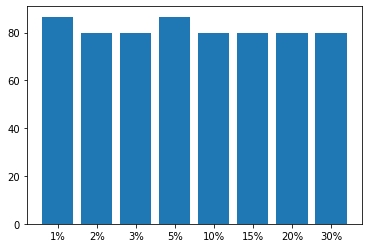

In [416]:
plt.bar(result_df["Threshold%"], result_df["Accuracy"])
plt.show()

<BarContainer object of 8 artists>

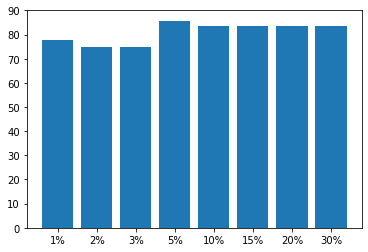

In [417]:
plt.bar(result_df["Threshold%"], result_df["Precision(Delay)"])

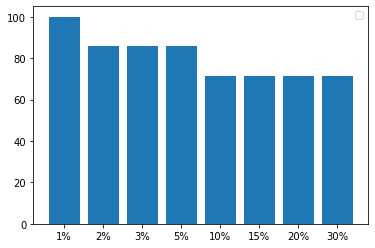

In [418]:
plt.bar(result_df["Threshold%"], result_df["Recall(Delay)"])
plt.legend()

### -------- Result: Cut-off can be considered as 1% or 5% ---------

In [419]:
# RESULT FOR 1% THRESHOLD TIME
a[["DELIVERED_LATE_BY_TIME?", "ALERT"]].value_counts()

DELIVERED_LATE_BY_TIME?  ALERT
No                       0        7
Yes                      1        5
                         0        2
No                       1        1
dtype: int64

In [420]:
# RESULT FOR 2% THRESHOLD TIME
a[["DELIVERED_LATE_BY_TIME?", "ALERT"]].value_counts()

DELIVERED_LATE_BY_TIME?  ALERT
No                       0        7
Yes                      1        5
                         0        2
No                       1        1
dtype: int64

In [421]:
# RESULT FOR 3% THRESHOLD TIME
a[["DELIVERED_LATE_BY_TIME?", "ALERT"]].value_counts()

DELIVERED_LATE_BY_TIME?  ALERT
No                       0        7
Yes                      1        5
                         0        2
No                       1        1
dtype: int64

In [422]:
# RESULT FOR 5% THRESHOLD TIME
a[["DELIVERED_LATE_BY_TIME?", "ALERT"]].value_counts()

DELIVERED_LATE_BY_TIME?  ALERT
No                       0        7
Yes                      1        5
                         0        2
No                       1        1
dtype: int64

In [423]:
# RESULT FOR 10% THRESHOLD TIME
a[["DELIVERED_LATE_BY_TIME?", "ALERT"]].value_counts()

DELIVERED_LATE_BY_TIME?  ALERT
No                       0        7
Yes                      1        5
                         0        2
No                       1        1
dtype: int64

In [424]:
# RESULT FOR 15% THRESHOLD TIME
a[["DELIVERED_LATE_BY_TIME?", "ALERT"]].value_counts()

DELIVERED_LATE_BY_TIME?  ALERT
No                       0        7
Yes                      1        5
                         0        2
No                       1        1
dtype: int64

In [425]:
# RESULT FOR 20% THRESHOLD TIME
a[["DELIVERED_LATE_BY_TIME?", "ALERT"]].value_counts()

DELIVERED_LATE_BY_TIME?  ALERT
No                       0        7
Yes                      1        5
                         0        2
No                       1        1
dtype: int64

In [426]:
# RESULT FOR 30% THRESHOLD TIME
a[["DELIVERED_LATE_BY_TIME?", "ALERT"]].value_counts()

DELIVERED_LATE_BY_TIME?  ALERT
No                       0        7
Yes                      1        5
                         0        2
No                       1        1
dtype: int64

### Setp 5: Whom and When to send?

As described the notification should be sent to: customers whose delivery is POTENTIAL to get delayed 
       
        1. This is done by score the Google API distance and ETA
        2. Calculate the difference between current time and expected time of delivery as "TIME LEFT"
        3. Subtract "TIME LEFT" to Google API's "ETA" time
        4. Difference should not exceed 5% of the total time estimated (in the forst row)
        5. If the reading exceeds the threshold, send "ALERT"
        6. Further business rules can be formed to control the frequncy of notification based on severity 